In [75]:
import pandas as pd
import numpy as np
from benchmarks import MinVarianceMethod, MaxSharpeMethod
from rl.model_rl import RLEnvironment, RLAgent, QEstimator
from environment import Environment
from utils import get_stats, cumulative_pct_change
from model_lstm import main as LstmModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math


# Loading Environments

In [2]:
env = Environment()
minvar_method = MinVarianceMethod(allow_short=True)
maxsharpe_method = MaxSharpeMethod(allow_short=True)

# EDA

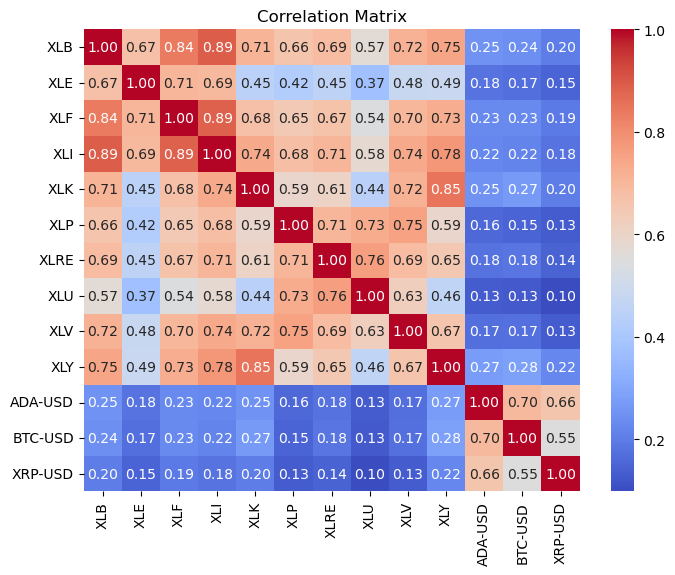

In [3]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(env.returns.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Training and Prediction

## LSTM Model

In [ ]:
def run_benchmarks_and_lstm():
    N_ASSETS = len(env.returns.columns)
    weights_equal, weights_minvar, weights_maxsharpe, weights_lstm = [], [], [], []
    result_equal, result_minvar, result_maxsharpe, result_lstm = [], [], [], []


    testing_period_returns = env.get_state(
        end=1300, 
        lookback=1300
        )

    holding_period_returns = env.get_state(
        end= 1700, 
        lookback = 400
    )

    ################## BENCHMARK MODELS

    ### 1. Equal weights
    equal_weights = np.ones(N_ASSETS) / N_ASSETS

    r = np.dot(holding_period_returns, equal_weights)
    result_equal.append(r.tolist())
    weights_equal.append(equal_weights)

    ### 2. Min variance
    min_var_weights = minvar_method.get_optimal_weights(testing_period_returns)

    r = np.dot(holding_period_returns, min_var_weights)
    result_minvar.append(r.tolist())
    weights_minvar.append(min_var_weights)

    ### 3. Max Sharpe
    max_sharpe_weights = maxsharpe_method.get_optimal_weights(testing_period_returns)

    r = np.dot(holding_period_returns, max_sharpe_weights)
    result_maxsharpe.append(r.tolist())
    weights_maxsharpe.append(max_sharpe_weights)


    ################## Price Predictors put here: aka LSTM and RL
    prices = env.get_prices(
        end=1700, 
        lookback=1700
    )
    res, rmse_score, predicted_prices, actual_prices = LstmModel(filtered_data=prices, holding_period=400)
    predicted_returns = predicted_prices.pct_change().dropna() * 100
    lstm_weights = maxsharpe_method.get_optimal_weights(predicted_returns)

    r = np.dot(holding_period_returns, lstm_weights)
    result_lstm.append(r.tolist())
    weights_lstm.append(lstm_weights)

    ### SAVING THE DATA INTO CSVs to be used later
    weights_dict = {
    "Equal": weights_equal[0],
    "Min Var": weights_minvar[0],
    "Max Sharpe": weights_minvar[0],
    "LSTM": weights_lstm[0]
    }   
    weights_df = pd.DataFrame(weights_dict)
    weights_df.to_csv("final_weight_results.csv")

    predicted_prices.to_csv("predicted_prices_lstm.csv")
    actual_prices.to_csv("actual_prices_lstm.csv")
    rmse_score.to_csv("rsme_score_lstm.csv")

    returns_dict = {
        "Equal": result_equal[0],
        "Min Var": result_minvar[0],
        "Max Sharpe": result_maxsharpe[0],
        "LSTM": result_lstm[0]
        }
    returns_df = pd.DataFrame(returns_dict)
    returns_df.to_csv("final_returns_all_models.csv")
    

# Only run this if want to train model again
# run_benchmarks_and_lstm()

In [185]:
## RELOAD ALL VARIABLES TO BE USED
holding_period_returns = env.get_state(
    end= 1700, 
    lookback = 400
)


actual_prices = pd.read_csv("actual_prices_lstm.csv")
predicted_prices = pd.read_csv("predicted_prices_lstm.csv")
rmse_score = pd.read_csv("rsme_score_lstm.csv", index_col=0)
weights_df = pd.read_csv("final_weight_results.csv", index_col=0)
returns_df = pd.read_csv("final_returns_all_models.csv", index_col=0)

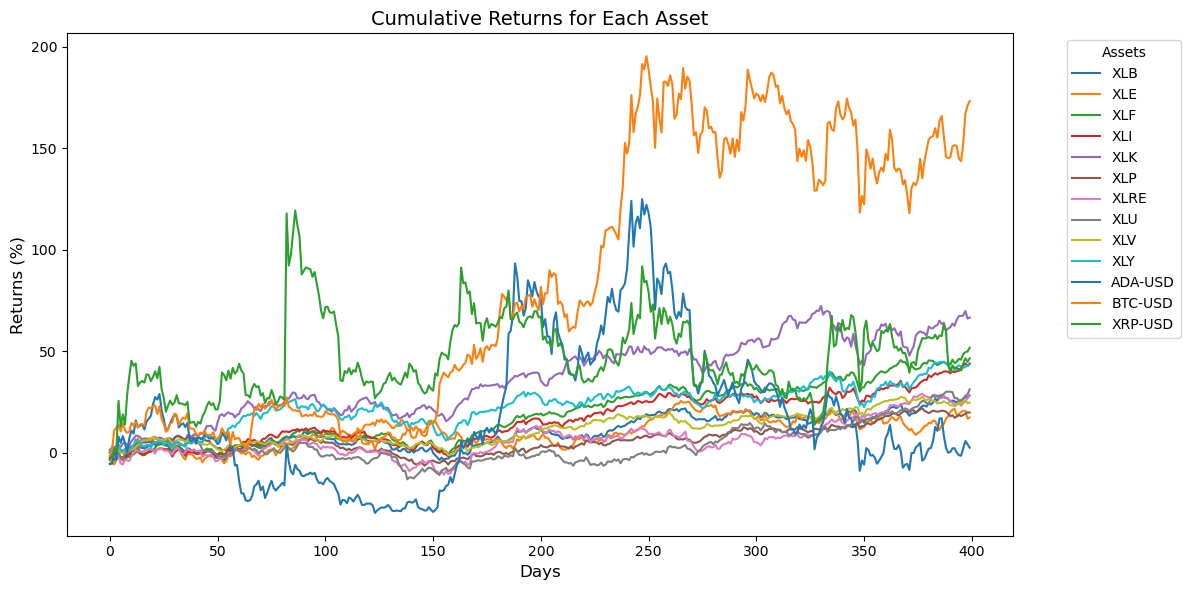

In [186]:
asset_list = env.prices.columns.to_list()

plt.figure(figsize=(12, 6))  # Create a figure for the plot
for stock in asset_list:
    cumulative_returns = cumulative_pct_change(holding_period_returns[stock])
    plt.plot(cumulative_returns, label=stock)  # Plot cumulative returns for the asset

# Add labels and title
plt.xlabel("Days", fontsize=12)
plt.ylabel("Returns (%)", fontsize=12)
plt.title("Cumulative Returns for Each Asset", fontsize=14)

# Add a legend
plt.legend(title="Assets", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## RL Model

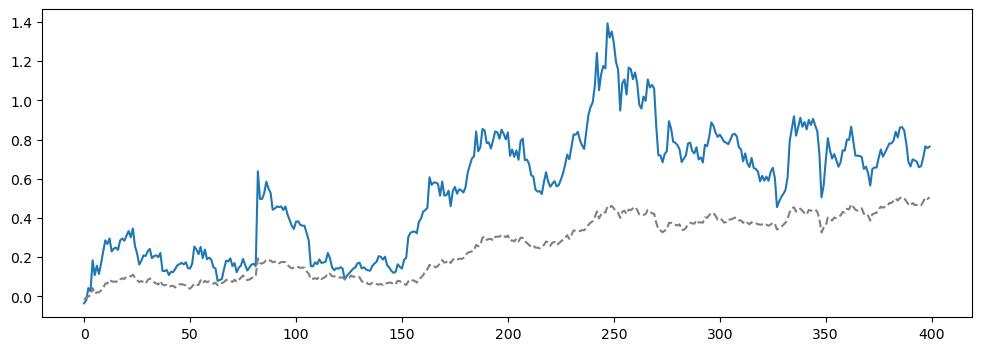

In [ ]:
def run_rl_model():
    # Clean data used for testing below
    data_rl = pd.read_csv("df_price.csv", index_col=0)
    data_rl = data_rl.dropna()
    data_rl.iloc[1210:1701].to_csv("rl/data/df_price_test_400.csv")
    env_test = RLEnvironment(input_file="rl/data/df_price_test_400.csv", 
                            observe_window = 90, 
                            rebalance_window = 30)

    agent = RLAgent(n_action=61)
    agent.load_model("rl/model/q_estimator_final_v2_0_retsum.pkl")

    performance_rl = agent.q_predict(env_test) 

# 

# Evaluation

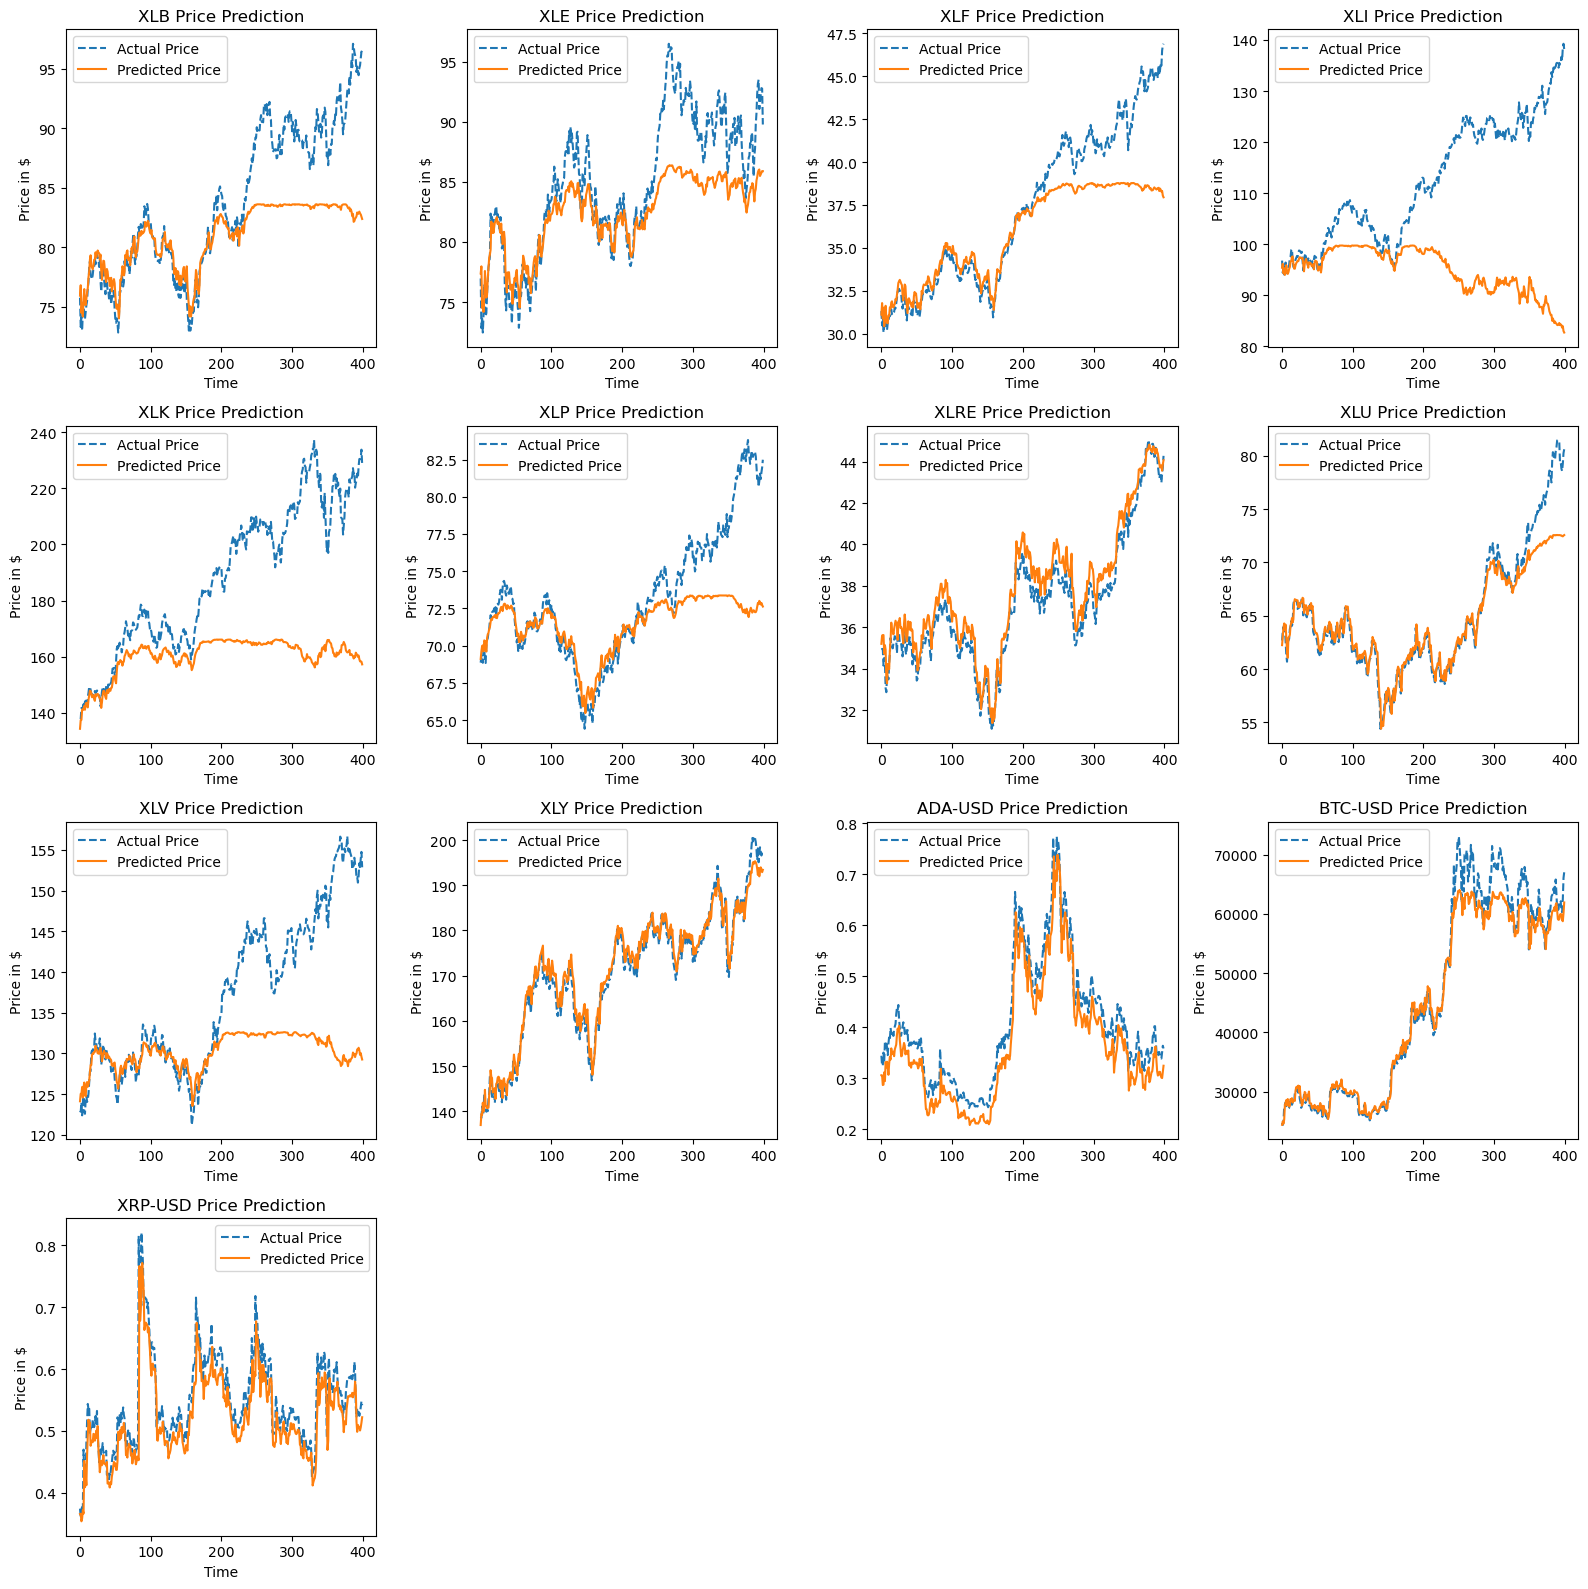

In [187]:
num_stocks = len(asset_list)
num_cols = 4
num_rows = math.ceil(num_stocks / num_cols)

# Create subplots with the calculated rows and columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 4))
axes = axes.flatten() 
for i, stock in enumerate(asset_list):
    ax = axes[i]  # Get the current subplot
    ax.plot(actual_prices[stock], label=f"Actual Price", linestyle='--')
    ax.plot(predicted_prices[stock], label=f"Predicted Price", linestyle='-')
    ax.set_title(f"{stock} Price Prediction")
    ax.set_xlabel('Time')
    ax.set_ylabel('Price in $')
    ax.legend()

for j in range(len(axes)):
    if j >= num_stocks:
        axes[j].axis('off')

plt.tight_layout()

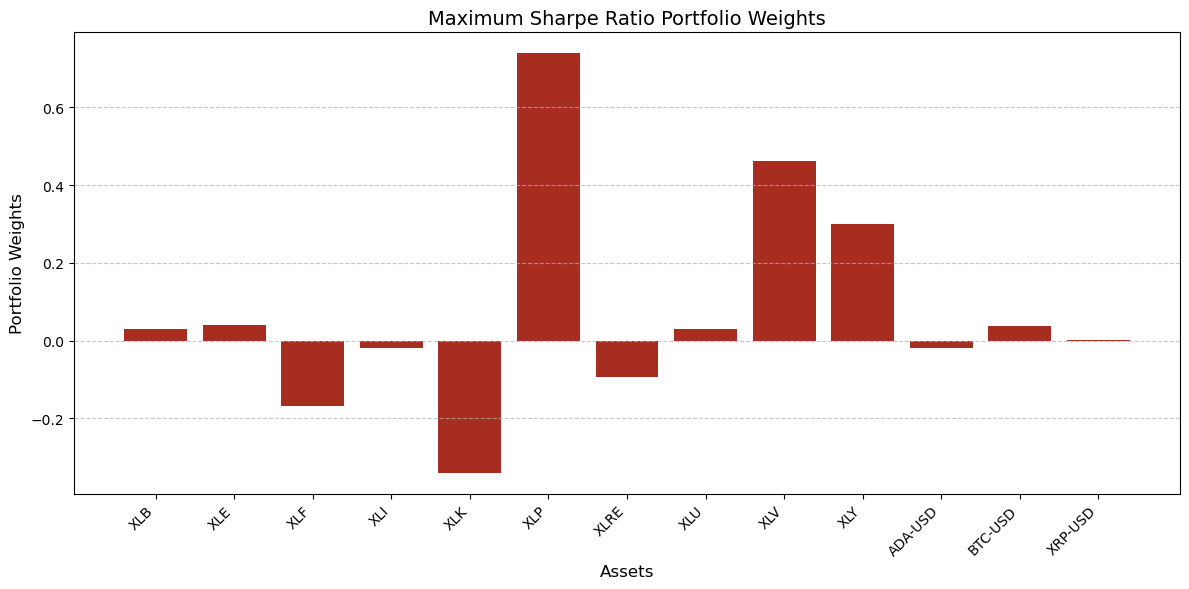

In [188]:
max_sharpe_ratio_color = '#a82d21'
plt.figure(figsize=(12, 6))
plt.bar(asset_list, weights_df["Max Sharpe"], color=max_sharpe_ratio_color)

# Add labels and title
plt.xlabel("Assets", fontsize=12)
plt.ylabel("Portfolio Weights", fontsize=12)
plt.title("Maximum Sharpe Ratio Portfolio Weights", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

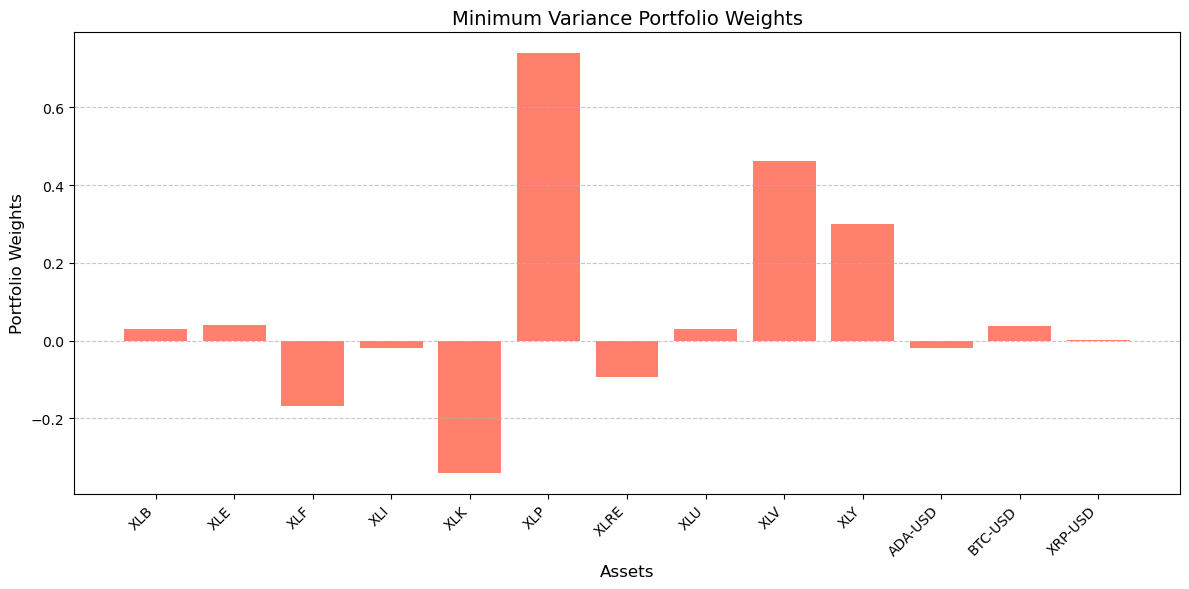

In [189]:
min_var_color = '#ff806c'
plt.figure(figsize=(12, 6))
plt.bar(asset_list, weights_df["Min Var"], color=min_var_color)

# Add labels and title
plt.xlabel("Assets", fontsize=12)
plt.ylabel("Portfolio Weights", fontsize=12)
plt.title("Minimum Variance Portfolio Weights", fontsize=14)
plt.xticks(rotation=45, ha='right')  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

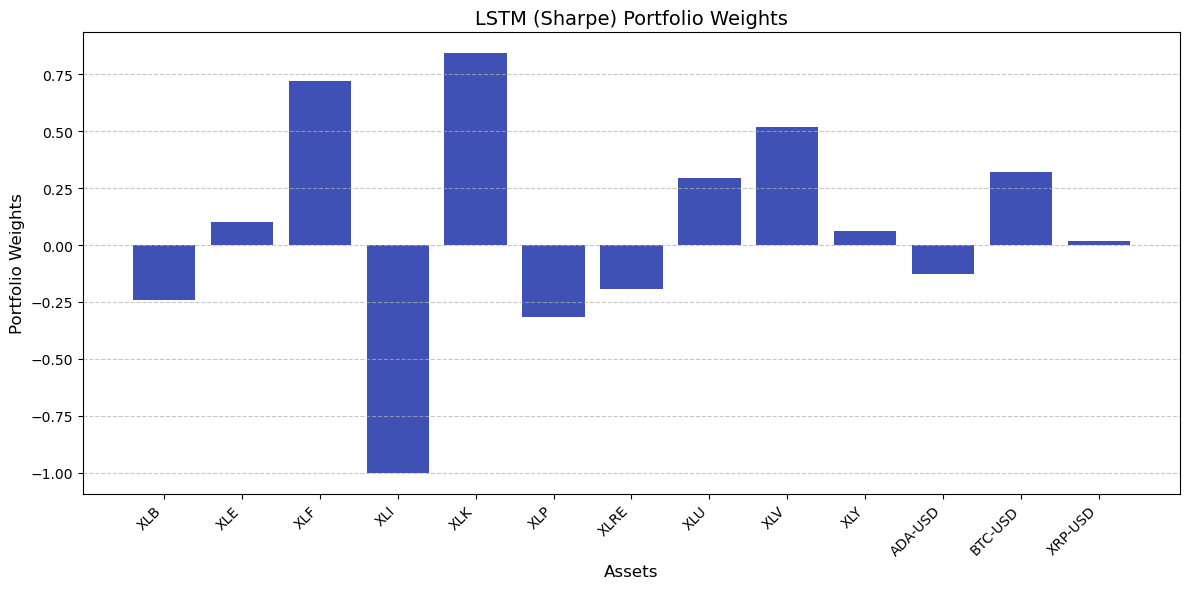

In [190]:
lstm_color = '#3f51b5'
plt.figure(figsize=(12, 6))
plt.bar(asset_list, weights_df["LSTM"], color=lstm_color)

# Add labels and title
plt.xlabel("Assets", fontsize=12)
plt.ylabel("Portfolio Weights", fontsize=12)
plt.title("LSTM (Sharpe) Portfolio Weights", fontsize=14)
plt.xticks(rotation=45, ha='right')  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

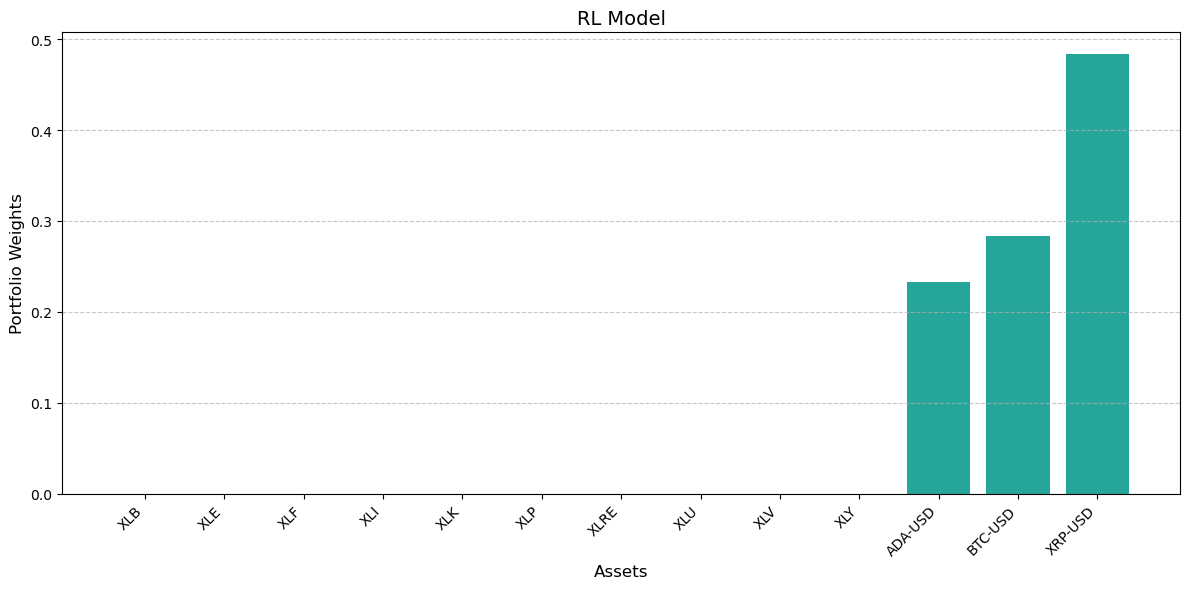

In [191]:
rl_color  = '#26a69a'

plt.figure(figsize=(12, 6))
plt.bar(asset_list, performance_rl.portfolio_composition[0], color=rl_color)


# Add labels and title
plt.xlabel("Assets", fontsize=12)
plt.ylabel("Portfolio Weights", fontsize=12)
plt.title("RL Model", fontsize=14)
plt.xticks(rotation=45, ha='right')  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

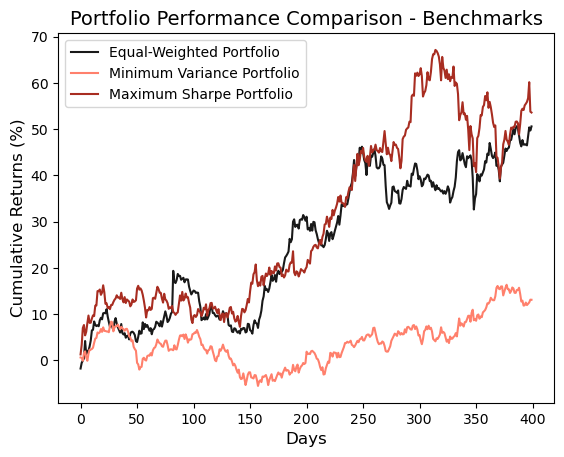

In [193]:
# flatten into list and compare results

equal_weights_daily_returns = returns_df["Equal"]
minvar_method_daily_returns = returns_df["Min Var"]
maxsharpe_method_daily_returns = returns_df["Max Sharpe"]
lstm_method_daily_returns = returns_df["LSTM"]

equal_weights_color = "#191919";

plt.figure()
plt.xlabel("Days", fontsize=12)
plt.ylabel("Returns (%)")
plt.plot(cumulative_pct_change(equal_weights_daily_returns), label = "Equal-Weighted Portfolio", color = equal_weights_color)
plt.plot(cumulative_pct_change(minvar_method_daily_returns), label = "Minimum Variance Portfolio", color = min_var_color)
plt.plot(cumulative_pct_change(maxsharpe_method_daily_returns), label = "Maximum Sharpe Portfolio", color =max_sharpe_ratio_color)
plt.ylabel("Cumulative Returns (%)", fontsize=12)
plt.title("Portfolio Performance Comparison - Benchmarks", fontsize=14)
plt.legend(fontsize=10)
plt.show()


In [113]:
rl_model_daily_returns = [x*100 for x in performance_rl.portfolio_returns]

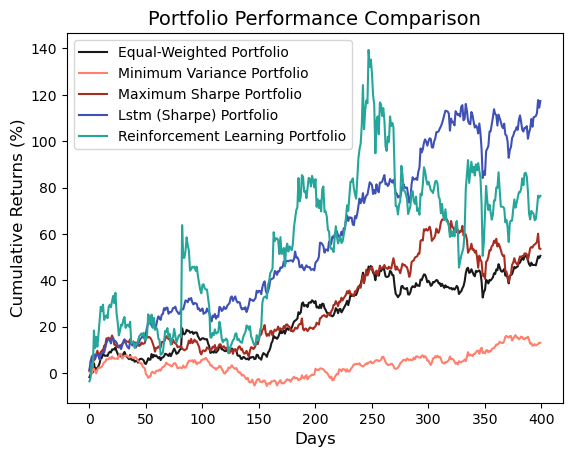

In [137]:
plt.figure()
plt.xlabel("Days", fontsize=12)
plt.ylabel("Returns (%)")
plt.plot(cumulative_pct_change(equal_weights_daily_returns), label = "Equal-Weighted Portfolio", color =equal_weights_color)
plt.plot(cumulative_pct_change(minvar_method_daily_returns), label = "Minimum Variance Portfolio", color =min_var_color)
plt.plot(cumulative_pct_change(maxsharpe_method_daily_returns), label = "Maximum Sharpe Portfolio", color =max_sharpe_ratio_color)
plt.plot(cumulative_pct_change(lstm_method_daily_returns), label = "Lstm (Sharpe) Portfolio", color =lstm_color)
plt.plot(cumulative_pct_change(rl_model_daily_returns), label = "Reinforcement Learning Portfolio", color = rl_color)

plt.ylabel("Cumulative Returns (%)", fontsize=12)
plt.title("Portfolio Performance Comparison", fontsize=14)
plt.legend(fontsize=10)
plt.show()

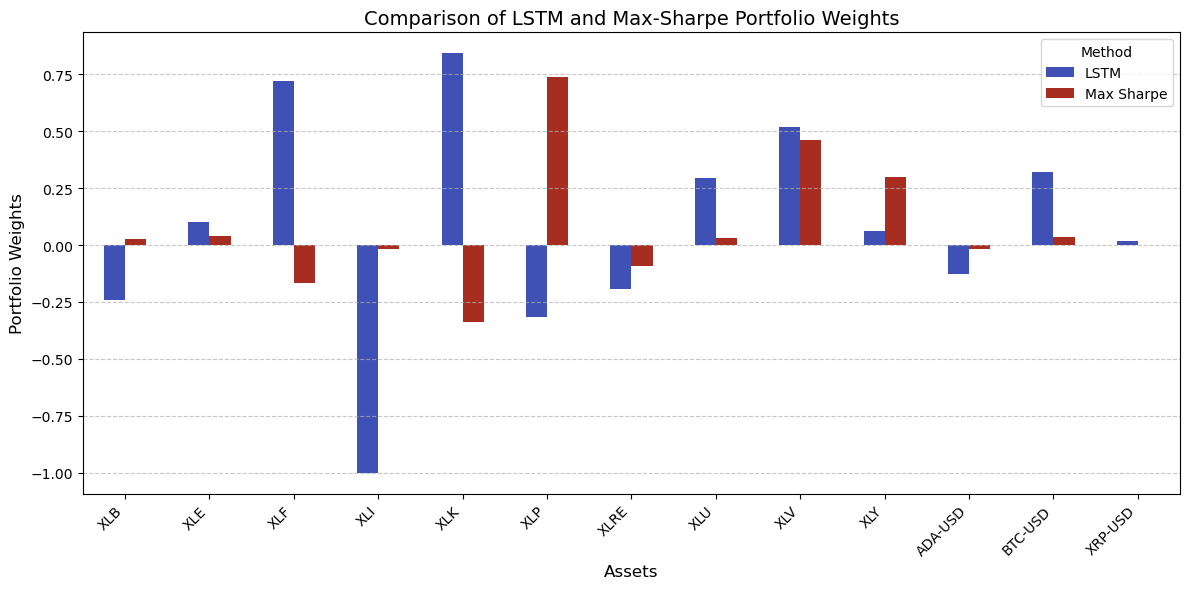

In [173]:
new_dict = {}

for i, stock in enumerate(asset_list):
    new_dict.update({
        stock: {
            "LSTM":weights_df["LSTM"][i],
            "Max Sharpe": weights_df["Max Sharpe"][i]
        }
    })

compiled = pd.DataFrame(new_dict)
compiled = compiled.transpose()

compiled.plot(kind='bar', figsize=(12, 6), color=[lstm_color, max_sharpe_ratio_color])

# Add labels and title
plt.xlabel('Assets', fontsize=12)
plt.ylabel('Portfolio Weights', fontsize=12)
plt.title('Comparison of LSTM and Max-Sharpe Portfolio Weights', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend
plt.legend(title="Method", loc='best')

# Show the plot
plt.tight_layout()
plt.show()


In [140]:
results = []

equal_weights_stats = get_stats(equal_weights_daily_returns)
equal_weights_stats["Name"] = "Equal Weights"
results.append(equal_weights_stats)

minvar_method_stats = get_stats(minvar_method_daily_returns)
minvar_method_stats["Name"] = "Minimum Variance"
results.append(minvar_method_stats)

maxsharpe_method_stats = get_stats(maxsharpe_method_daily_returns)
maxsharpe_method_stats["Name"] = "Maximum Sharpe"
results.append(maxsharpe_method_stats)

lstm_model_stats = get_stats(lstm_method_daily_returns)
lstm_model_stats["Name"] = "Lstm (Sharpe)"
results.append(lstm_model_stats)

rl_model_stats = get_stats(rl_model_daily_returns)
rl_model_stats["Name"] = "RL"
results.append(rl_model_stats)



stats = pd.DataFrame(results).set_index("Name")
stats

UPDATED returns
UPDATED returns
UPDATED returns
UPDATED returns
UPDATED returns


,Cumulative Return,Sharpe Ratio,Maximum Drawdown,Value at Risk
Name,,,,
Equal Weights,50.574080,0.098418,0.700969,1.416276
Minimum Variance,13.111975,0.045101,1.656732,1.188248
Maximum Sharpe,53.583446,0.094130,0.553066,1.709625
Lstm (Sharpe),117.355474,0.152441,0.320234,1.825479
RL,76.450066,0.054781,0.865667,5.140794


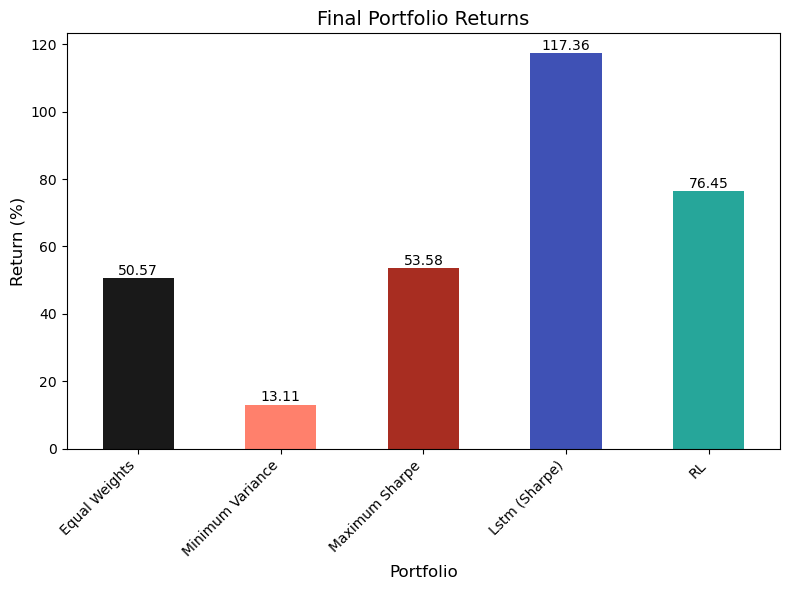

In [147]:
all_model_colors = [equal_weights_color, min_var_color,max_sharpe_ratio_color,lstm_color, rl_color]
stats["Cumulative Return"].plot(kind='bar', figsize=(8, 6), color=all_model_colors)

plt.xlabel('Portfolio', fontsize=12)
plt.ylabel('Return (%)', fontsize=12)
plt.title('Final Portfolio Returns', fontsize=14)
plt.xticks(rotation=45, ha='right') 

for i, v in enumerate(stats["Cumulative Return"]):
    plt.text(i, v + 1, f"{v:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

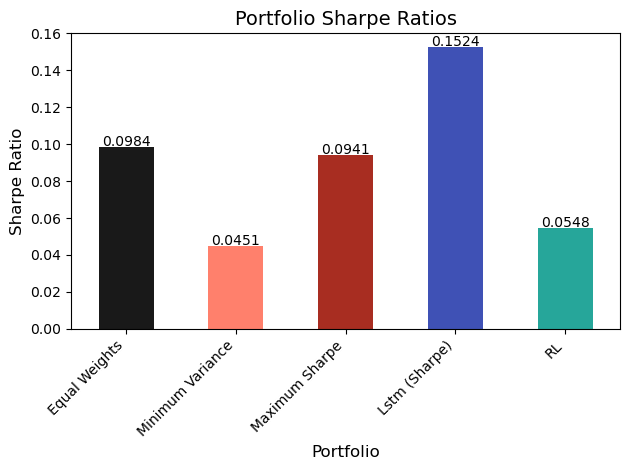

In [142]:
stats["Sharpe Ratio"].plot(kind='bar',color=all_model_colors)


plt.xlabel('Portfolio', fontsize=12)
plt.ylabel('Sharpe Ratio', fontsize=12)
plt.title('Portfolio Sharpe Ratios', fontsize=14)
plt.xticks(rotation=45, ha='right') 

for i, v in enumerate(stats["Sharpe Ratio"]):
    plt.text(i, v+0.0005, f"{v:.4f}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()

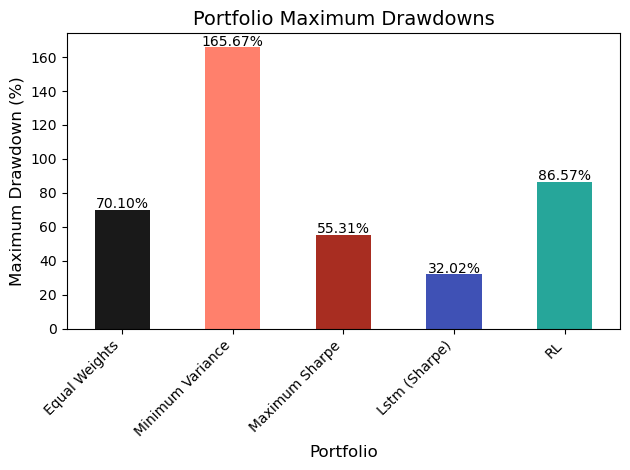

In [143]:
drawdown_updated = stats["Maximum Drawdown"] * 100
drawdown_updated.plot(kind='bar',color=all_model_colors)


plt.xlabel('Portfolio', fontsize=12)
plt.ylabel('Maximum Drawdown (%)', fontsize=12)
plt.title('Portfolio Maximum Drawdowns', fontsize=14)
plt.xticks(rotation=45, ha='right') 

for i, v in enumerate(drawdown_updated):
    plt.text(i, v + 0.8, f"{v:.2f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

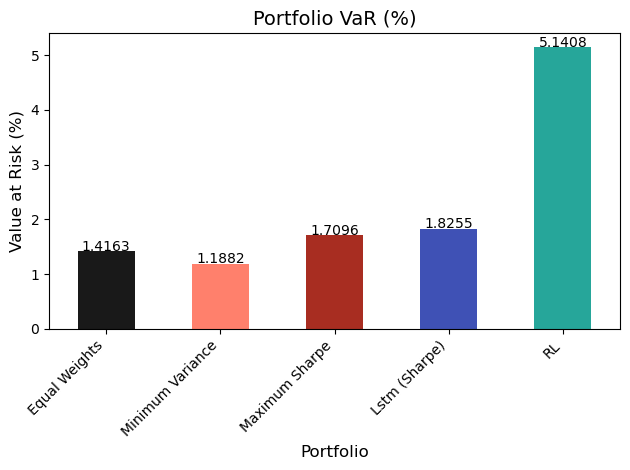

In [145]:
stats["Value at Risk"].plot(kind='bar',color=all_model_colors)

plt.xlabel('Portfolio', fontsize=12)
plt.ylabel('Value at Risk (%)', fontsize=12)
plt.title('Portfolio VaR (%)', fontsize=14)
plt.xticks(rotation=45, ha='right') 

for i, v in enumerate(stats["Value at Risk"]):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()